In [1]:
# LIB UPLOAD CELL:
###########################################

import MAIN_MODULE as mm
import sys
path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/'
path_EVAL = path_main + 'EVALUATION/BRIDGEON_STM_60/'
path_PRODUCT =  path_EVAL + 'PRODUCTION/'
sys.path.append(path_main)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca
from matplotlib.colors import BoundaryNorm
from qutip.qip.operations import hadamard_transform
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from time import time
from tqdm import tqdm

##setup_list = [22,25,33,43]
setup = 43

In [2]:
# OLD SETUP EVALUATION (AVARAGE STM 60):
b = 0.5
c = 0.23

UA = mm.hadamard_transform(1)
UB =  mm.hadamard_transform(1)

args = (UA, UB)


ent_meas_operator_list = mm.two_par_measurement_anzats(b,c, False)
sep_meas_operator_list = mm.two_par_measurement_anzats(b,c, True, *args)

# EVALUATION CELL:
###########################################
#num_states_samples = 1
multiplexing = 10
# SPECIFYING MEASUREMENT ANZATS:

# FUNCTION EVALUATE IMPLEMENT ANALYSIS WITH  BRIDGE SET TO ON !!!
def evaluate_bridge(init_state, signal, depolarization_prob, operator_list):
    # Initialization
    inp = signal[2000:2200]
    result = mm.np.zeros((len(inp), multiplexing, mm.n_qubits_total))
    state = init_state
    # PRECPROCESSING --> IT IS NECESSARY TO SATISFY ECHO STATE PROPERTY. 2000 temporal preproc. steps.
    for i in range(2000):
        state = mm.encoding_step(state, signal[i])
        state = mm.evolution_step(state)
        state = mm.entangled_channel_step_old(state, depolarization_prob, operator_list) # NONSELECTIVE MEAS CHANNEL
    
    for n in range(len(inp)): # READOUT  - >  TEMPORAL MULTIPLEXING 
        state = mm.encoding_step(state, inp[n])
        for m in range(multiplexing):
            state = mm.evolution_step(state)
            state = mm.entangled_channel_step_old(state, depolarization_prob, operator_list)

            for site in range(mm.n_qubits_total):
                state, outcome = mm.separated_measurement_step(state, site )
                result[n, m, site] = outcome

    return result

In [3]:
#signal = [mm.np.random.choice(2) for _ in range(2200)]
#mm.np.save(path_EVAL + str(s)+'signal', signal) 
signal =  mm.np.load(path_EVAL + str(0) + 'signal'  + '.npy')
num_signal_samples = 1

In [4]:
#mm.np.random.seed(23450)


t1 = time()
# EXECUTION CELL:
###########################################
init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
init_state = init_state * init_state.dag()
init_state = init_state.full()

for s in range(num_signal_samples):
    print('Signal sample num:' +  str(s))
    
    #signal = mm.np.load(path_main + '/data/complex_signal_9_9.npy')
    results_ENT = evaluate_bridge(init_state, signal, 0, ent_meas_operator_list ) # ENTANGLED BASIS
    results_SEP = evaluate_bridge(init_state, signal, 0, sep_meas_operator_list) # SEPARABLE BASIS
    mm.np.save(path_EVAL + str(s) + 'TOTAL_res_OLD_ENT' + str(0) + str(setup), results_ENT)
    mm.np.save(path_EVAL + str(s) + 'TOTAL_res_OLD_SEP' + str(0), results_SEP)
     
t2 = time ()

def learning(results,signal,offset):
    y_true = mm.np.array(signal[2000-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubits_total) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    W = mm.np.linalg.inv(X.T @ X + 1e-17 * mm.np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, signal, offset):
    y_true = mm.np.array(signal[2000-offset:2100-offset]) * 2 - 1
    y_test = mm.np.array(signal[2100-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubits_total) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:100]
    X_test = X[100:]
    W = mm.np.linalg.inv(X_train.T @ X_train + 1e-17 *mm.np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test

offset = 6
res_ENT, y_true_ENT = learning(results_ENT,signal, 0)
res_gen_ENT, y_true_gen = learning_gen(results_ENT,signal, offset)

mm.np.save(path_EVAL + str(s) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(setup), res_ENT)
mm.np.save(path_EVAL + str(s) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(setup),  y_true_ENT)
mm.np.save(path_EVAL + str(s) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(setup), res_gen_ENT)
mm.np.save(path_EVAL + str(s) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(setup),  y_true_gen)

res_SEP, y_true = learning(results_SEP,signal, 0)


def get_memory_acc(result, signal):
    acc = []
    for i in range(100):
        res, y_true = learning(result, signal,i)
        acc.append((mm.np.mean(res * y_true) - mm.np.mean(res) * mm.np.mean(y_true))**2/mm.np.var(res)/mm.np.var(y_true))
    return acc

def learn_acc(d_max, result, signal):
    acc = []
    for d in range(d_max):
        res, y_true = learning_gen(result,signal, d)
        res = res/mm.np.max(mm.np.abs(res))
        acc.append(mm.np.linalg.norm(res - y_true))
        #acc.append(np.sum(res - y_true)**2)
        
    return mm.np.array(acc)

memory_acc = get_memory_acc(results_ENT, signal)
mm.np.save(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(setup), memory_acc )
memory_cap = mm.np.array([mm.np.sum(memory_acc[0: d]) for d in range(1, len(memory_acc))])
mm.np.save(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(setup), memory_cap)
learning_acc = learn_acc(100,results_ENT, signal)
mm.np.save(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(setup), learning_acc)

MA_SEP = get_memory_acc(results_SEP, signal)
MC_SEP = mm.np.array([mm.np.sum(MA_SEP[0: d]) for d in range(1, len(MA_SEP))])
LA_SEP = learn_acc(100,results_SEP, signal)
    




print('EVALUATION TIME IS {}'.format(t2 - t1))
print('CURRENT SETUP IS {}'. format(setup))

Signal sample num:0
EVALUATION TIME IS 14.420639038085938
CURRENT SETUP IS 43


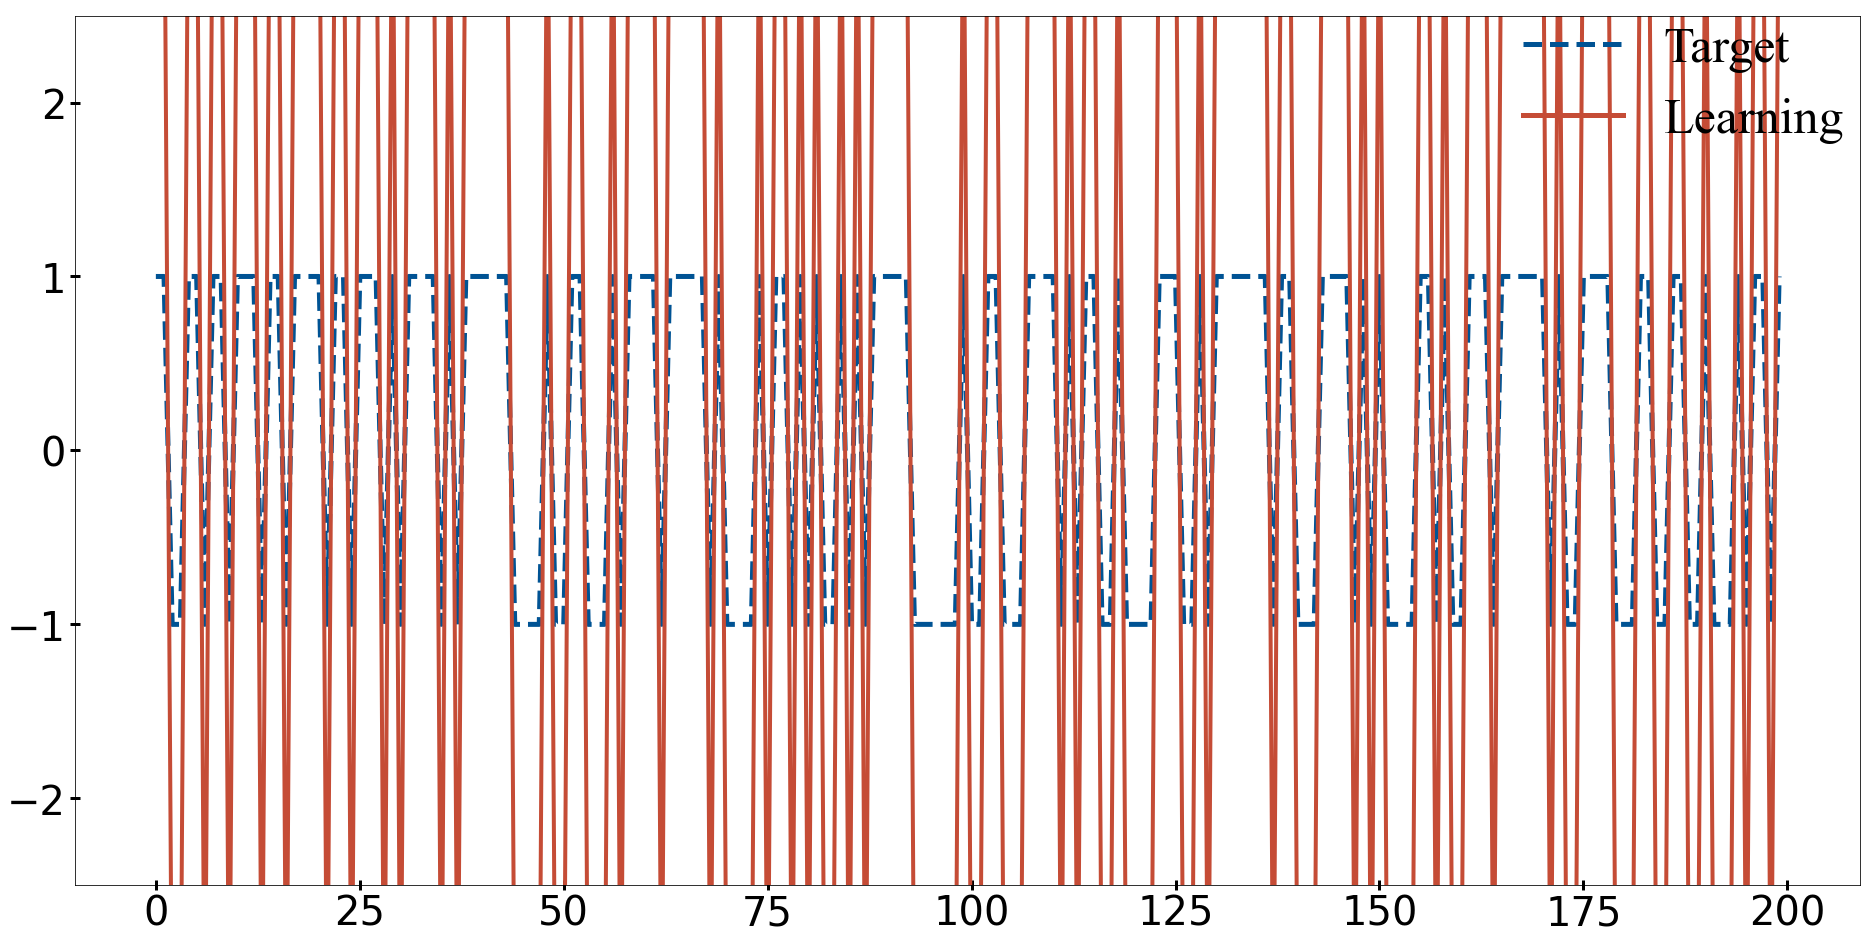

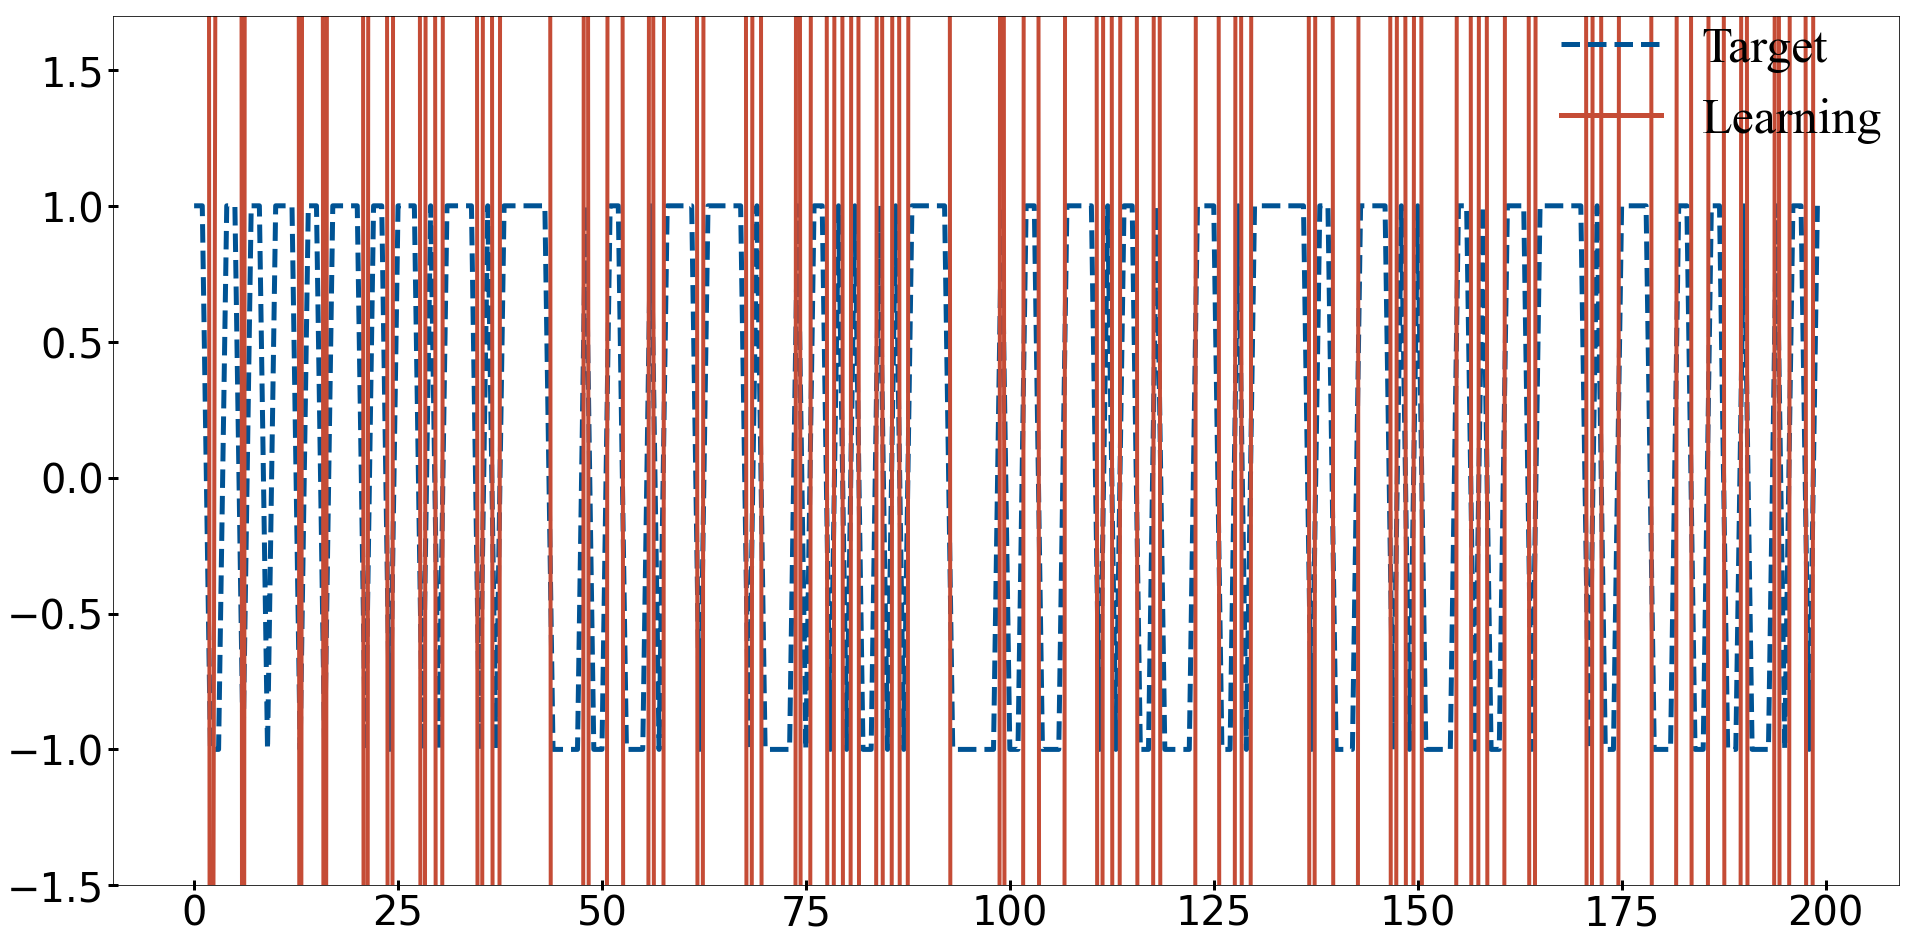

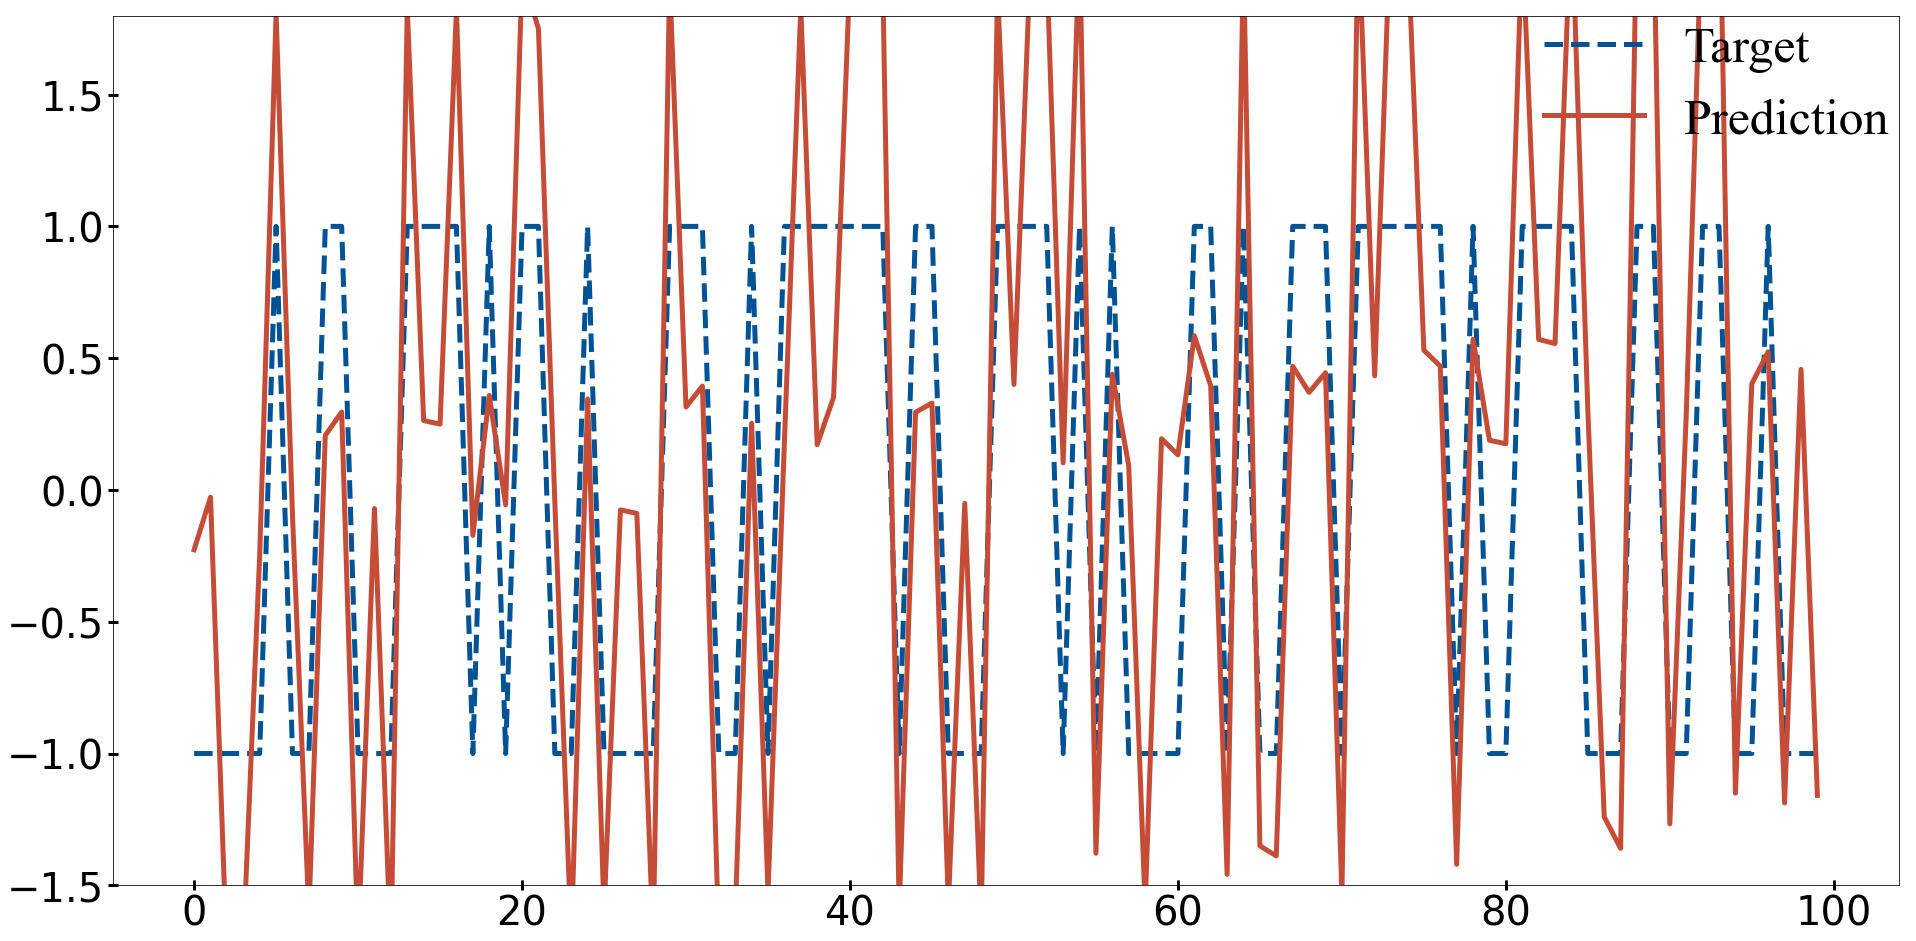

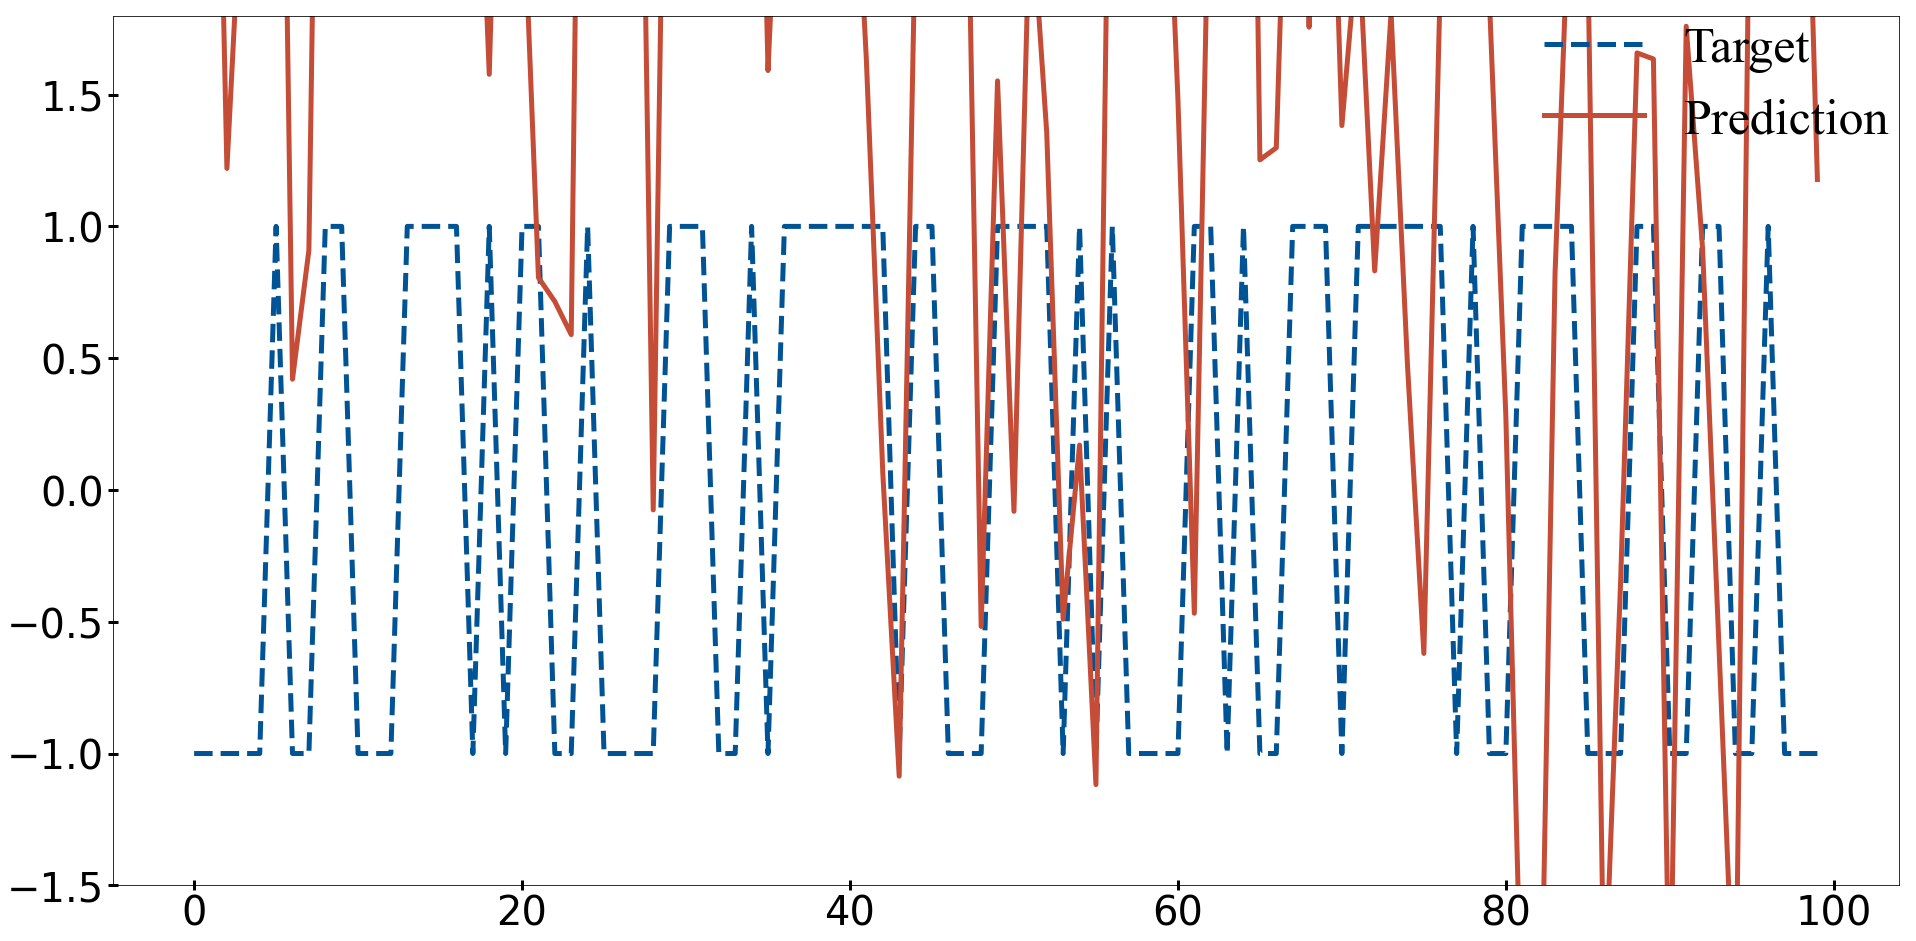

In [5]:
num_sig = mm.np.random.choice(num_signal_samples)
#setup_list = [13,24,25,33,34] 

res_ENT_22 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(22)+'.npy')
y_true_22 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(22)+'.npy')
res_gen_ENT_22 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(22)+'.npy')
y_true_gen_22 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(22)+'.npy')

# res_ENT_23 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(23)+'.npy')
# y_true_23 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(23)+'.npy')
# res_gen_ENT_23 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(23)+'.npy')
# y_true_gen_23 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(23)+'.npy')

# res_ENT_24 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(24)+'.npy')
# res_gen_ENT_24 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(24)+'.npy')
# y_true_24 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(24)+'.npy')
# y_true_gen_24 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(24)+'.npy')

res_ENT_25 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(25)+'.npy')
res_gen_ENT_25 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(25)+'.npy')
y_true_25 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(25)+'.npy')
y_true_gen_25 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(25)+'.npy')

# res_ENT_32 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(32)+'.npy')
# res_gen_ENT_32 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(32)+'.npy')
# y_true_32 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(32)+'.npy')
# y_true_gen_32 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(32)+'.npy')

res_ENT_33 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(33)+'.npy')
res_gen_ENT_33 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(33)+'.npy')
y_true_33 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(33)+'.npy')
y_true_gen_33 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(33)+'.npy')

# res_ENT_34 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(34)+'.npy')
# res_gen_ENT_34 = mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(34)+'.npy')
# y_true_34 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(34)+'.npy')
# y_true_gen_34 =  mm.np.load(path_EVAL + str(num_sig) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(34)+'.npy')

res_ENT_43 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_ENT' + str(0)+'_SETUP_'+str(43)+'.npy')
res_gen_ENT_43 = mm.np.load(path_EVAL + str(0) + 'TOTAL_res_gen_ENT' + str(0)+'_SETUP_'+str(43)+'.npy')
y_true_43 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_true' + str(0)+'_SETUP_'+str(43)+'.npy')
y_true_gen_43 =  mm.np.load(path_EVAL + str(0) + 'TOTAL_y_gen_true' + str(0)+'_SETUP_'+str(43)+'.npy')
#results_SEP = mm.np.load(path_EVAL + str(num_sig) + 'res_OLD_SEP' + str(0) + '.npy')


font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
# LEARNING PLOT -- ENTANGLED
fig_ENT = plt.figure(figsize = (32, 16))
ax_ENT = plt.subplot(111)
ax_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_ENT.set_ylim(-2.5, 2.5)
plt.plot(y_true_25, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_ENT_25, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_ENT.savefig(path_PRODUCT + 'TOTAL_LEARNING_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)

# LEARNING PLOT -- SEPARABLE
fig_SEP = plt.figure(figsize = (32, 16))
ax_SEP = plt.subplot(111)
ax_SEP.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_SEP.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_SEP, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_SEP.savefig(path_PRODUCT + 'TOTAL_LEARNING_p=0_rand_sig_SEP' + '.svg', format='svg', dpi=3000)


offset = 6
# GENERALIZATION PLOT -  ENTANGLED
fig_gen_ENT = plt.figure(figsize = (32, 16))
ax_gen_ENT = plt.subplot(111)
ax_gen_ENT.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen_ENT.set_ylim(-1.5, 1.8)
plt.plot(y_true_gen_25, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen_ENT_25, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_gen_ENT.savefig(path_PRODUCT + 'TOTAL_GEN_p=0_rand_sig_ENT' + '.svg', format='svg', dpi=3000)

# GENERALIZATION PLOT - SEPARABLE
res_gen_SEP, y_true_gen = learning_gen(results_SEP,signal, offset)
fig_gen_SEP = plt.figure(figsize = (32, 16))
ax_gen_SEP = plt.subplot(111)
ax_gen_SEP.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen_SEP.set_ylim(-1.5, 1.8)
plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen_SEP, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)
fig_gen_SEP.savefig(path_PRODUCT + 'TOTAL_PREDICTION_p=0_rand_sig_SEP' + '.svg', format='svg', dpi=3000)



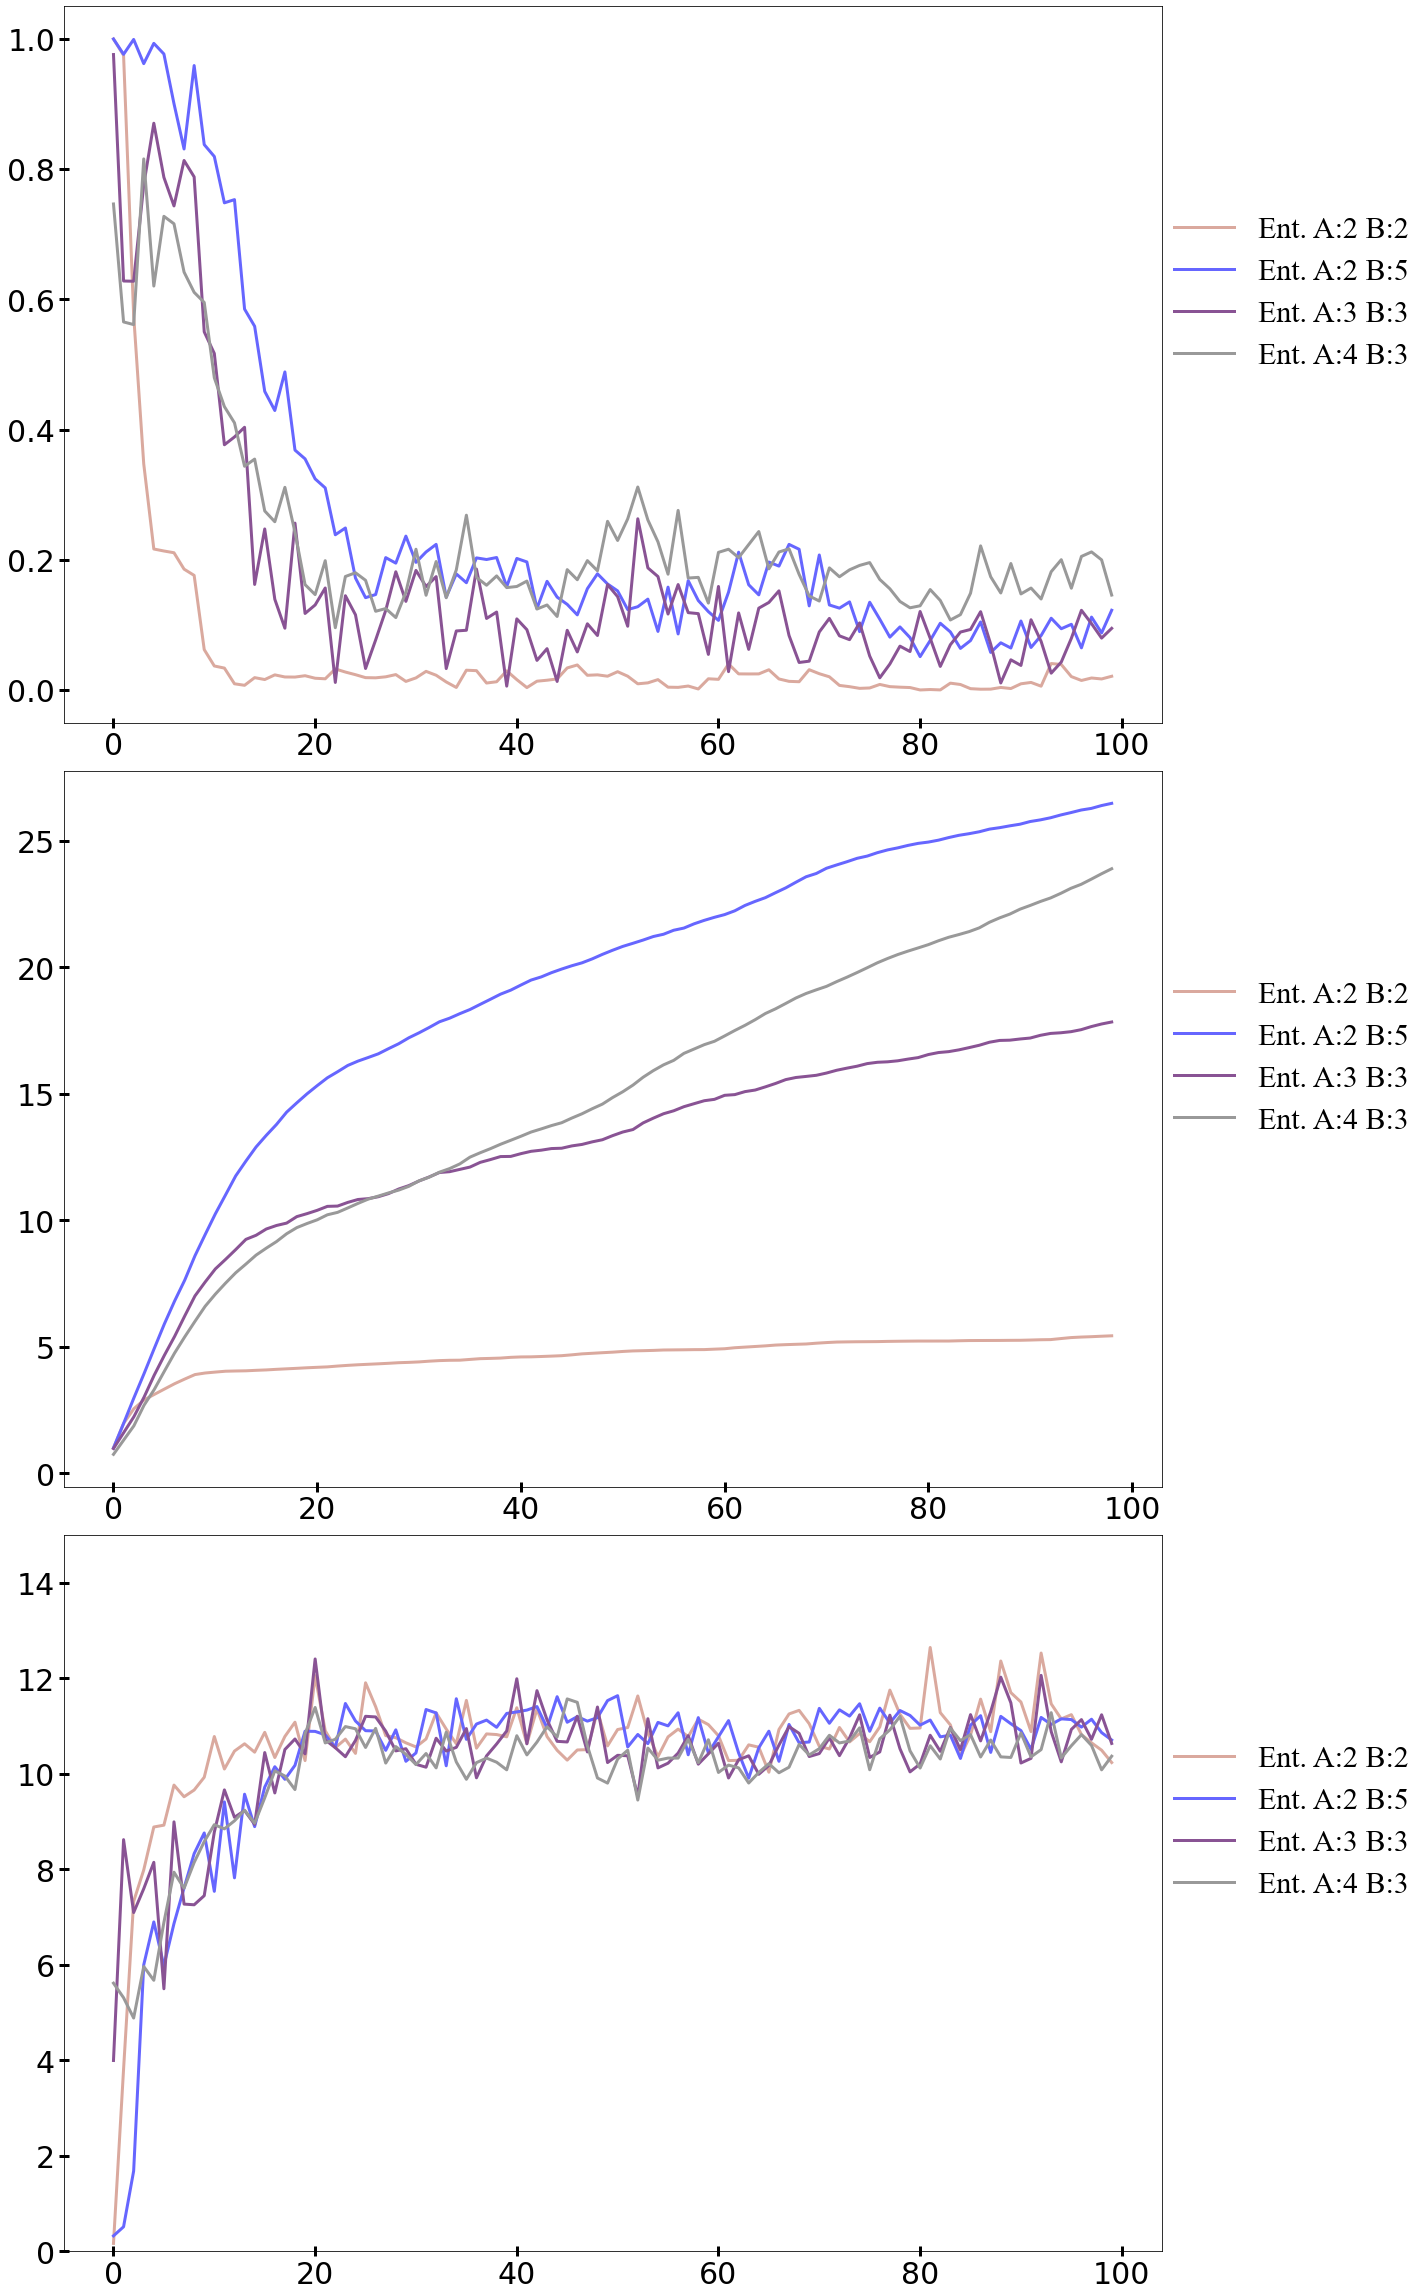

In [6]:

#setup_list = [22,23,24,25,33,34,43] 
MA_22 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(22)+'.npy')
#MA_23 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(23)+'.npy')
#MA_24 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(24)+'.npy')
MA_25 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(25)+'.npy')
#MA_32 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(32)+'.npy')
MA_33 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(33)+'.npy')
#MA_34 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(34)+'.npy')
MA_43 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MA' + str(0)+'_SETUP_'+str(43)+'.npy')


MC_22 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(22)+'.npy')
#MC_23 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(23)+'.npy')
#MC_24 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(24)+'.npy')
MC_25 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(25)+'.npy')
#MC_32 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(32)+'.npy')
MC_33 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(33)+'.npy')
#MC_34 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(34)+'.npy')
MC_43 = mm.np.load(path_EVAL + str(s) + 'TOTAL_MC' + str(0)+'_SETUP_'+str(43)+'.npy')


LA_22 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(22)+'.npy')
#LA_23 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(23)+'.npy')
#LA_24 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(24)+'.npy')
LA_25 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(25)+'.npy')
#LA_32 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(32)+'.npy')
LA_33 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(33)+'.npy')
#LA_34 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(34)+'.npy')
LA_43 = mm.np.load(path_EVAL + str(s) + 'TOTAL_LA' + str(0)+'_SETUP_'+str(43)+'.npy')




fig3, ax3 = plt.subplots(3, figsize = (20,32))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 30,
        }

ax3[0].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[1].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[2].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')


ax3[0].plot(MA_22, label = 'Ent. A:2 B:2', linewidth = 3,  color = '#DAA99E')
#ax3[0].plot(MA_23, label = 'Ent. A:2 B:3', linewidth = 3,  color = '#754C24')
#ax3[0].plot(MA_24, label = 'Ent. A:2 B:4', linewidth = 3,  color = '#FF9933')
ax3[0].plot(MA_25, label = 'Ent. A:2 B:5', linewidth = 3,  color = '#6666FF')
#ax3[0].plot(MA_32, label = 'Ent. A:3 B:2', linewidth = 3, color = '#005394')
ax3[0].plot(MA_33, label = 'Ent. A:3 B:3', linewidth = 3, color = '#895394')
#ax3[0].plot(MA_34, label = 'Ent. A:3 B:4', linewidth = 3,  color = '#66CC66')
ax3[0].plot(MA_43, label = 'Ent. A:4 B:3', linewidth = 3,  color = '#999999')
ax3[0].legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.25, 0.6))

ax3[1].plot(MC_22, label = 'Ent. A:2 B:2', linewidth = 3,  color = '#DAA99E')
#ax3[1].plot(MC_23, label = 'Ent. A:2 B:3', linewidth = 3,  color = '#754C24')
#ax3[1].plot(MC_24, label = 'Ent. A:2 B:4', linewidth = 3,  color = '#FF9933')
ax3[1].plot(MC_25, label = 'Ent. A:2 B:5', linewidth = 3,  color = '#6666FF')
#ax3[1].plot(MC_32, label = 'Ent. A:3 B:2', linewidth = 3, color = '#005394')
ax3[1].plot(MC_33, label = 'Ent. A:3 B:3', linewidth = 3, color = '#895394')
#ax3[1].plot(MC_34, label = 'Ent. A:3 B:4', linewidth = 3,  color = '#66CC66')
ax3[1].plot(MC_43, label = 'Ent. A:4 B:3', linewidth = 3,  color = '#999999')
ax3[1].legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.25, 0.6))

ax3[2].plot(LA_22, label = 'Ent. A:2 B:2', linewidth = 3,  color = '#DAA99E')
#ax3[2].plot(LA_23, label = 'Ent. A:2 B:3', linewidth = 3,  color = '#754C24')
#ax3[2].plot(LA_24, label = 'Ent. A:2 B:4', linewidth = 3,  color = '#FF9933')
ax3[2].plot(LA_25, label = 'Ent. A:2 B:5', linewidth = 3,  color = '#6666FF')
#ax3[2].plot(LA_32, label = 'Ent. A:3 B:2', linewidth = 3, color = '#005394')
ax3[2].plot(LA_33, label = 'Ent. A:3 B:3', linewidth = 3, color = '#895394')
#ax3[2].plot(LA_34, label = 'Ent. A:3 B:4', linewidth = 3,  color = '#66CC66')
ax3[2].plot(LA_43, label = 'Ent. A:4 B:3', linewidth = 3,  color = '#999999')
ax3[2].legend(loc = 'center right', prop = font1, frameon = False, bbox_to_anchor = (1.25, 0.6))
ax3[2].set_ylim(0,15)

plt.tight_layout()

fig3.savefig(path_PRODUCT + 'TOTAL_TASKS_BENCHMARKS' + '.svg', format='svg', dpi=1000)